#  <center> The Spectrogram of Electrical Brain Signals </center>#
## Developed by:##
# Kevin Mchado Gamboa#

In this notebookwe we will explore the spectrogram technique in a EEG signals and perform an analysis over it.


### Libraries Needed

In [1]:
import os
from os.path import dirname as up
path = up(os.getcwd())
os.chdir(path)

import mne
import numpy as np
import numpy as pd
import ppfunctions_1 as ppf
import matplotlib.pyplot as plt

### Functioons Implemented

In [2]:
def vec_time(x,sf):
    return np.linspace(0, len(x)/sf, len(x))

### Loading eeg

In [46]:
data = mne.io.read_raw_edf(path+'/Tests/Test_data/ST7011J0-PSG.edf', preload=True)
#data = mne.io.read_raw_edf(path+'/Tests/Test_data/PN00-1.edf', preload=True)
sf = int(data.info['sfreq'])

# Extracting a sample of the entired signal
dn = 0
sa = 20000
eeg_sample = data._data[dn][:sa]

Extracting EDF parameters from /home/colossus/Desktop/Meine/AIDiagnostics/tech_dev_projects/EEG-tech-projects/Repo/e-Brain-signals/Tests/Test_data/ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...


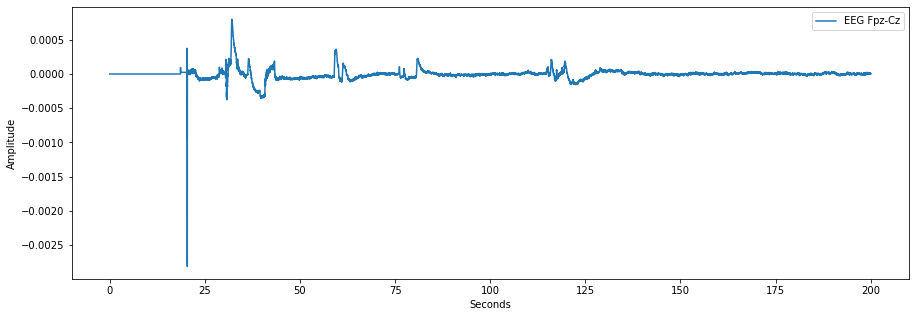

In [47]:
plt.figure(figsize=(15,5))
plt.plot(vec_time(eeg_sample,sf), eeg_sample, label = str(data.ch_names[dn]))
plt.ylabel('Amplitude')
plt.xlabel('Seconds')
plt.legend()

Imaging plotting the signal spectrogram

/home/colossus/Desktop/Meine/AIDiagnostics/tech_dev_projects/EEG-tech-projects/Repo/e-Brain-signals/ppfunctions_1.py:723: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack( signal[i:i+number_time_samples] for i in range(0,len(signal)-number_time_samples, stepsize))


(-0.5, 19999.5, -5.099903863761213, 49.5)

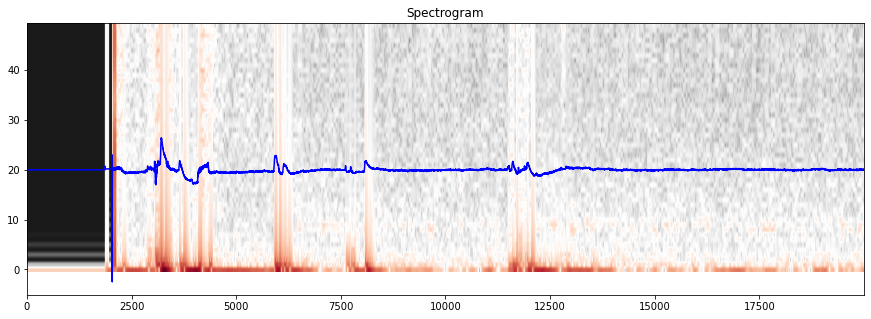

In [104]:
### Spectrogram Parameters ###
f = 100
fft_size = f # 1000 samples represent 500ms in time  # window size for the FFT
step_size = int(fft_size/f) # distance to slide along the window (in time) if devided by 40 is good
spec_thresh = 5.5 # threshold for spectrograms (lower filters out more noise)

spectrogram = abs(ppf.move_spec(ppf.aid_spectrogram(eeg_sample.astype('float64'), fft_size = fft_size, 
                                     step_size = step_size, log = True, thresh = spec_thresh)))

plt.figure(figsize=(15,5))
plt.imshow((spectrogram), origin='lower', cmap='RdGy') # gist_heat, afmhot
plt.plot(20+(8000*eeg_sample), 'b')
plt.title('Spectrogram')
plt.axis('tight')

### Simulating realtime EEG spectrogram

In this section, assuming a sampling frequency of 100Hz, we used 100 samples at a time to perform the spectrogram. 
To achieve this, first, lets slice the original signal and then check that the sliced signal is equal to the original one when re-constructed.

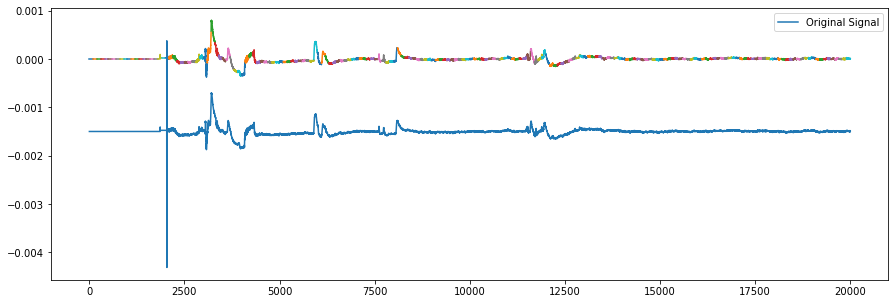

In [101]:
from skimage import util
sl = sf
# Slicing the signal 
slices = util.view_as_windows(eeg_sample, window_shape = (sl,),step = sl )
# Reconstructing tthe signal in a for loop
plt.figure(figsize=(15,5))
for i, chunk in enumerate(slices):
    plt.plot(np.linspace(i*sl,(i+1)*sl, sl),chunk)
plt.plot(eeg_sample - 0.0015, label = 'Original Signal')
plt.legend()
plt.show()

Now, having verified the signal reconstruction, we can perform the spectrogram algorithm in a for loop, for each slice. The Spectrogram algorithm have the next steps:

1. Define a window
2. Apply the FFT to each chunk times the window
3. get the magnitude of the FFT

In [102]:
# 1. window definition
win = 0.8 - .9 * np.sin(2 * np.pi * np.arange(sl) / (sl - 1))

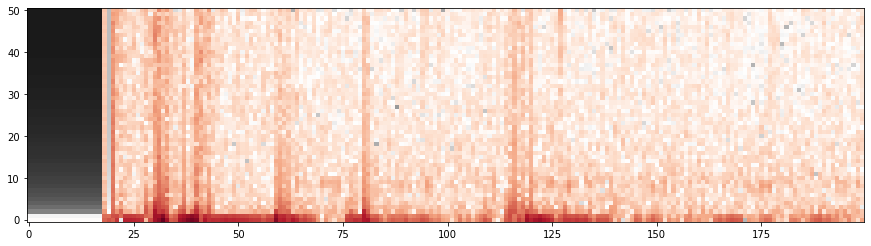

In [116]:
spec = []
for i, chunk in enumerate(slices):
    fourier = np.fft.rfft(chunk*win) / (100*sf)
    spec.append(20*np.log10(abs(fourier)))

# Converting List as array
Rspectrogram = np.asarray(np.transpose(spec))
Rspectrogram /= Rspectrogram.max()
Rspectrogram[Rspectrogram<-spec_thresh] = -spec_thresh

plt.figure(figsize=(15,5))
plt.imshow(Rspectrogram, origin='lower', cmap='RdGy')

In [133]:
Rspectrogram.shape

(26, 2, 200)

<ipython-input-132-b365563c8b00>:7: RuntimeWarning: divide by zero encountered in log10
  spec.append(20*np.log10(abs(fourier)))


TypeError: Invalid shape (26, 2, 200) for image data

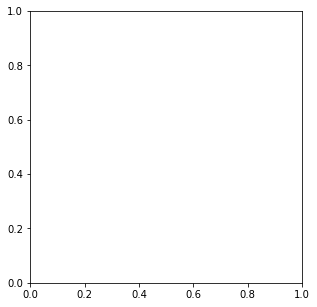

In [132]:
cut = fft_size // 2
spec = []
for i, chunk in enumerate(slices):
    X = ppf.overlapping(chunk, stepsize=50, number_time_samples=50)

    fourier = np.fft.rfft(X)[:,:cut]
    spec.append(20*np.log10(abs(fourier)))

# Converting List as array
Rspectrogram = np.asarray(np.transpose(spec))
Rspectrogram /= Rspectrogram.max()
Rspectrogram[Rspectrogram<-spec_thresh] = -spec_thresh

plt.figure(figsize=(15,5))
plt.imshow(Rspectrogram, origin='lower', cmap='RdGy')

In [128]:
cut = fft_size // 2
X = ppf.overlapping(spec[0], stepsize=50, number_time_samples=50)

In [122]:
print(eeg_sample.shape, X.shape)

(20000,) (20000, 100)


In [109]:
Rspectrogram = np.asarray(np.transpose(Rspectrogram))

(51, 200)

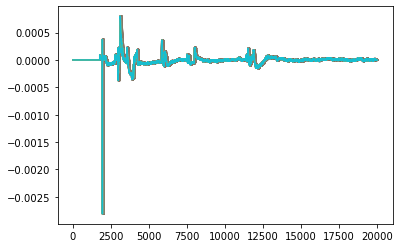

In [126]:
for i in range (100):
    plt.plot(X[:,i])

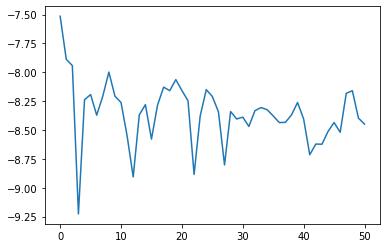

In [77]:
plt.plot(np.log10(np.sqrt(abs(np.fft.rfft(chunk*win) / (100*sf))**2)))

(-0.5, 19999.5, -3.944186046511624, 27.829921259842518)

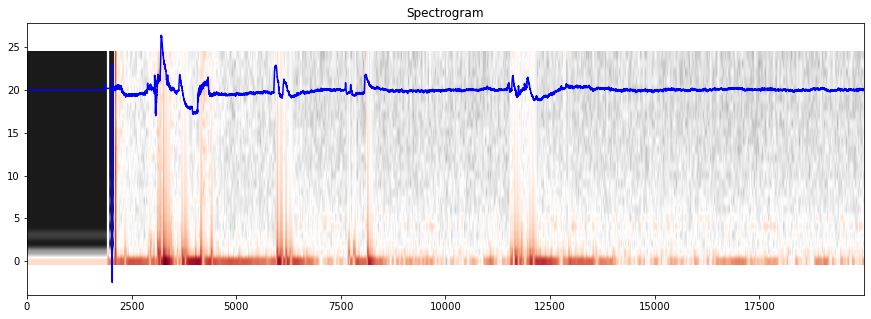

In [43]:
# loop through the signal in x
for samp_i in range(eeg_sample.size):

values = []

# loop through the window:
for wind_i in range(int(1 - window), 1):

  if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
    # out of range
    continue

  # sample is in range and not nan, use it:
  if not(np.isnan(x[samp_i + wind_i])):
    values += [x[samp_i + wind_i]]

# calculate the mean in the window for this point in the output:
output[samp_i] = FUN(values)